## Goal

Make a 16 panel plot showing the posteriors from randomized SFHs, label each age-bin, and show the area inside a certain threshold limit.

In [579]:
%pylab inline
from astropy.io import fits
import dtdutils
reload(dtdutils)
import dtdplotutils as plot_dtd
reload(plot_dtd)
import os
from scipy import stats
#Allows you to access an environment variable.
DTDpath = os.getenv('DTD')
matplotlib.rcParams['xtick.labelsize']=17
matplotlib.rcParams['axes.linewidth'] = 2.0

Populating the interactive namespace from numpy and matplotlib


#### This code snippet gives a wide figure dimensions for a given number of parameters 

In [522]:
def isPrime(n): 
    """
    Checks if number 'n' is prime
    """
    return ~np.any([n%i==0 for i in range(2, n)])

def figsize_dims(n): 
    """
    Returns the appropriate number of dimensions for a given parameter. If 'n' is prime, it
    adds an extra row. 
    """
    
    if ~isPrime(n):
        nrows = np.max([[i] for i in range(1, int(n**0.5) + 1) if n % i == 0])
        return (nrows, n/nrows)
    else:
        nrows = np.max([[i] for i in range(1, int((n-1)**0.5) + 1) if (n-1) % i == 0])
        return (nrows + 1, n/nrows)
    
def odds_ratio(arr, bins, threshold):
    """
    Calculates the ratio of probabilities above and below the threshold limit. I'm currently defining the 
    threshold as the average detections per stellar mass per age bin. 
    """
    p_x, x = np.histogram(arr, bins, density=True)
    bin_w = x[1:] - x[:-1]
    custm = stats.rv_discrete(name='custm', values=(x[:-1] + bin_w/2.0, p_x*bin_w))
    odds = (1 - custm.cdf(threshold))/custm.cdf(threshold)
    return r'$\infty$' if np.isinf(odds) else str(np.around(odds, decimals=2))
    
def ageStrings(ages_lim):
    """
    Convert the ages into 'age Gyr' strings.
    """
    unit, val = [], []
    for age in ages_lim:
        if (np.log10(age) >= 6) & (np.log10(age) <9):
            unit.append('Myr ')
            val.append(str(np.around(age/1.0e6, decimals=1)))
        else:
            unit.append('Gyr ')
            val.append(str(np.around(age/1.0e9, decimals=1)))
        
    return val, unit

#### Main body of code

In [473]:
#~~~~~~~~ INPUT ~~~~~~~~~~~~~~~~~~~#
outfilePrefix = 'DTD_Plots/'
objName = 'RRLyrae'
obj_subtype_arr = ['All']
subfolderName = 'RRLyrae_linearSFH_2'
filePrefix = DTDpath + 'MCMC_DTD_fits/DTD_'+objName+'/' + subfolderName + '/'
sfhBinType = 'Unbinned'
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

#This reads in all the .FITS chain files in the directory, except the nominal, low, high.fits files
nIterations = len(glob.glob(filePrefix+'*.*'))-3


masterchain_randSFH = []
print 'Creating Master Chain...'
for i in range(nIterations):
    if i%10 == 0.:
        print i
    chain_randSFH, header = fits.getdata(filePrefix + 'LMC_MCMC_DTD_' + objName + obj_subtype_arr[0] + '_' + sfhBinType + \
                                         '_Iter' + plot_dtd.string_filenum(i) + '.fits', 0, header=True)
    masterchain_randSFH.append(chain_randSFH)

masterchain_randSFH = np.asarray(masterchain_randSFH)

nIt, nWalkers, chainLength, nParams = masterchain_randSFH.shape

print 'Flatten and average chains....'

ndim = masterchain_randSFH.shape[3]
chain_randSFH = masterchain_randSFH.reshape((-1, ndim))

#Choosing average chain from the superchain
nParams = int(chain_randSFH.shape[1])  #Number of DTD parameters
chainLength = int(chain_randSFH.shape[0]/nIterations*1.0)
print 'Length of chains : ', chainLength#Length of each DTD Markov Chain
chain_SFH = np.zeros((int(nParams), chainLength))
for par in range(nParams):
    chain_SFH[par] = np.random.choice(chain_randSFH[:,par], size=chainLength, replace=False)
    #You want the size of the randomly drawn chain to be the same size as the other chain, to 
    #normalize the statistical comparisons.
    
chain_SFH_rrl = chain_SFH.T

Creating Master Chain...
0
10
20
30
40
50
60
70
80
90
Flatten and average chains....
Length of chains :  240000


/Users/sumits2k/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in double_scalars


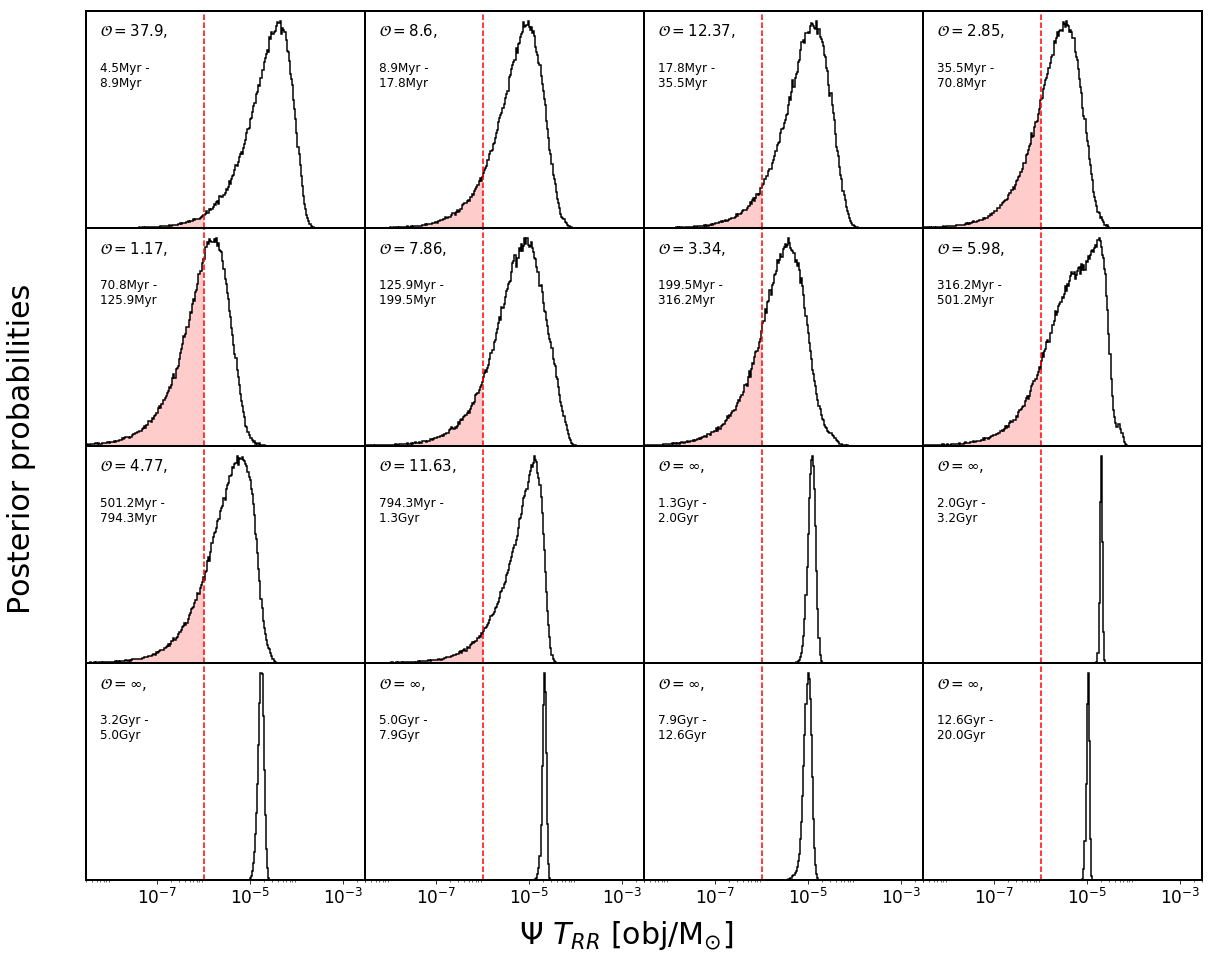

In [581]:
nrows, ncols = figsize_dims(nParams)
ages, ages_l, ages_u = dtdutils.sfh_ageBins(sfhBinType)
str_ages_l, str_ages_l_units = ageStrings(ages_l)
str_ages_u, str_ages_u_units = ageStrings(ages_u)
threshold = 1.0e-6


fig, axes = plt.subplots(nrows, ncols, figsize=(nrows*5, ncols*4), subplot_kw={'xticks': [], 'yticks': []})
bins = np.logspace(-10, -3, 300)
for i, ax in enumerate(axes.flat):
    odds = odds_ratio(chain_SFH_rrl[:, i], bins, threshold)
    agerange = str_ages_l[i] + str_ages_l_units[i] + '- \n' + str_ages_u[i] + str_ages_u_units[i]
    mask = chain_SFH_rrl[:, i] <= threshold
    ax.hist(chain_SFH_rrl[:, i][mask], bins=bins, histtype='bar', color='r', alpha=0.2, lw=0.)
    ax.hist(chain_SFH_rrl[:, i], bins=bins, lw=1.5, histtype='step', color='k')
    ax.text(0.05, 0.8, r'$\mathcal{O} = $'+ odds+',\n', fontsize=15, transform = ax.transAxes)
    ax.text(0.05, 0.65, agerange, fontsize=12, transform = ax.transAxes)
    ax.axvline(x = threshold, color = 'r', ls='--')
    ax.set_xscale('log')
    ax.set_xlim(3.0e-9, 3.0e-3)
    ax.legend(loc=2, fontsize=15)

fig.text(0.5, 0.07, r'$\Psi\ T_{RR}$ [obj/M$_{\odot}$]', fontsize = 30, ha='center')
fig.text(0.07, 0.5, 'Posterior probabilities', va='center', fontsize=30, rotation='vertical')

fig.subplots_adjust(hspace=0., wspace=0.)
plt.savefig(DTDpath + '/DTD_Plots/PosteriorGrid_OddsRatio.pdf', dpi=100)
plt.show()